# Problem set 10: Feature expansion (solution)

## Summary and general instructions

**Calculate and work with textual features beyond token unigram counts to predict volume publication dates.**

We're going to work this week with **regression** rather than classification. This means that, rather than trying to predict a class label for each text, we'll try to estimate a continuous value for each text (in this case, the date of first publication of the book).

Despite the move from classification to regression, the general `sklearn` workflow is similar. You'll still create features using a vectorizer of some sort, you'll still set up a predictor object (now a regressor rather than a classifier), you'll still fit your predictor to your feature data, and you'll still produce a vector of predictions (now in the form of numbers rather than discreet labels). You can still score and cross-validate your results, but now by measuring the coefficient of determination, $R^2$, rather than $F_1$.

We'll walk you through parts of this below. Good luck!

## Imports and setup

Recall that you can install SpaCy, if you haven't done so already, by running the following two lines in a code cell:

```
!conda install -c conda-forge spacy spacy-lookups-data -y
!python -m spacy download en_core_web_sm
```

In [1]:
# Imports
from   collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import requests
import seaborn as sns
from   sklearn.feature_extraction import DictVectorizer
from   sklearn.feature_extraction.text import TfidfVectorizer
from   sklearn.feature_selection import SelectKBest, mutual_info_regression
from   sklearn.linear_model import LinearRegression
from   sklearn.model_selection import cross_val_score
from   sklearn.preprocessing import StandardScaler
import spacy

In [2]:
# Working texts
# 10% samples of 40 US and GB novels
base_url = 'https://raw.githubusercontent.com/centre-for-humanities-computing/NER_workshop/master/texts_short/'
filenames = [
    'A-Alcott-Little_Women-1868-F.txt',
    'A-Cather-Antonia-1918-F.txt',
    'A-Chesnutt-Marrow-1901-M.txt',
    'A-Chopin-Awakening-1899-F.txt',
    'A-Crane-Maggie-1893-M.txt',
    'A-Davis-Life_Iron_Mills-1861-F.txt',
    'A-Dreiser-Sister_Carrie-1900-M.txt',
    'A-Freeman-Pembroke-1894-F.txt',
    'A-Gilman-Herland-1915-F.txt',
    'A-Harper-Iola_Leroy-1892-F.txt',
    'A-Hawthorne-Scarlet_Letter-1850-M.txt',
    'A-Howells-Silas_Lapham-1885-M.txt',
    'A-James-Golden_Bowl-1904-M.txt',
    'A-Jewett-Pointed_Firs-1896-F.txt',
    'A-London-Call_Wild-1903-M.txt',
    'A-Melville-Moby_Dick-1851-M.txt',
    'A-Norris-Pit-1903-M.txt',
    'A-Stowe-Uncle_Tom-1852-F.txt',
    'A-Twain-Huck_Finn-1885-M.txt',
    'A-Wharton-Age_Innocence-1920-F.txt',
    'B-Austen-Pride_Prejudice-1813-F.txt',
    'B-Bronte_C-Jane_Eyre-1847-F.txt',
    'B-Bronte_E-Wuthering_Heights-1847-F.txt',
    'B-Burney-Evelina-1778-F.txt',
    'B-Conrad-Heart_Darkness-1902-M.txt',
    'B-Dickens-Bleak_House-1853-M.txt',
    'B-Disraeli-Sybil-1845-M.txt',
    'B-Eliot-Middlemarch-1869-F.txt',
    'B-Forster-Room_View-1908-M.txt',
    'B-Gaskell-North_South-1855-F.txt',
    'B-Gissing-Grub_Street-1893-M.txt',
    'B-Hardy-Tess-1891-M.txt',
    'B-Mitford-Our_Village-1826-F.txt',
    'B-Radcliffe-Mysteries_Udolpho-1794-F.txt',
    'B-Shelley-Frankenstein-1818-F.txt',
    'B-Stevenson-Treasure_Island-1883-M.txt',
    'B-Thackeray-Vanity_Fair-1848-M.txt',
    'B-Trollope-Live_Now-1875-M.txt',
    'B-Wells-Time_Machine-1895-M.txt',
    'B-Woolf-Mrs_Dalloway-1925-F.txt'
]

# Randomize file order to avoid date sequence issues (B novels published earlier than A, on average)
random.shuffle(filenames)

# Use a dictionary to store full texts, keyed to file name
lit_texts = {}

# Pull texts from public GitHub (not our class site)
for f in filenames:
    lit_texts[f] = requests.get(base_url+f).text
    
# Gold labels (pub dates), parsed from filenames
y = [int(file.split('-')[3]) for file in filenames]

## 1. Simple vectorizer (5 points)

* Use the vectorizer below to create a feature matrix of normalized token counts for the 12 most frequently occurring words in the corpus. Your output matrix should have shape (40, 12). This is our **baseline** case. (3 points)
* Scale the feature matrix using a `StandardScaler()` object. (1 point)
* Print the resulting feature matrix shape and mean value (using `np.mean()`; it should be close to zero). (1 point)

In [3]:
simple_vectorizer = TfidfVectorizer(
    input = 'content',
    encoding = 'utf-8',
    strip_accents = 'unicode',
    lowercase = True,
    min_df = 0.5,
    max_features = 12,
    use_idf=False
)

In [4]:
# Vectorize, scale, print output
X_simple = simple_vectorizer.fit_transform(lit_texts[filename] for filename in filenames)
scaler = StandardScaler()
X_simple = scaler.fit_transform(X_simple.toarray())
print("Matrix shape:", X_simple.shape)
print("Matrix mean: ", np.mean(X_simple))

Matrix shape: (40, 12)
Matrix mean:  1.1472304587793285e-16


## 2. Simple linear regression (15 points)

Use a `LinearRegression()` object to predict the publication date of each novel in the corpus.

* Study the [`LinearRegression()` documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
* Note that the gold values, `y`, have already been supplied for you (see setup section above)
* Broadly speaking, you want to train your regressor by calling its `.fit()` method on your scaled input feature matrix and your gold labels, then use the fitted regressor to `.predict()` new y values given the same input. (5 points for fitting, 5 points for predicting)
    * This will provide a misleading sense of predictive performance, because training and testing on the same data encourages overfitting. We'll deal with this problem below.
* Plot your predicted publication dates as a function of the true publication dates. Nothing fancy needed, though +1 point if you do this with Seaborn's `regplot` to produce a line of best fit and a confidence interval. (5 points)

In [5]:
# Fit and predict
predictor = LinearRegression().fit(X_simple,y)
y_pred = predictor.predict(X_simple)

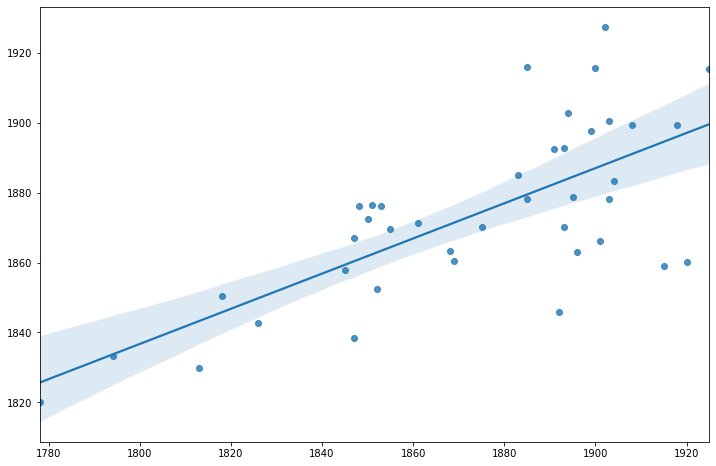

In [6]:
# Plot
plt.subplots(figsize=(12,8))
sns.regplot(y,y_pred)
plt.show()

## 3. Score your baseline regressor (15 points)

* First, score your trained regressor by calling its `.score()` method on the full input matrix and gold standard values. This calculates $R^2$, the coefficient of determination, which is an appropriate scoring metric for a regression problem. Print your score. It'll be somewhere near 0.5. (3 points)
* Second, use `sklearn`'s `cross_val_score` function to calculate a proper, non-overfitted $R^2$. Print your result. (7 points)
    * Use `scoring='r2'` and `cv=5` as parameters for your `cross_val_score`. 
    * See the [`cross_val_score` documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) for implementation details.
    * Your cross-validated $R^2$ value will be around -1.5 or -2.0, which is *terrible*. It means that just guessing the mean publication date as your answer for *every* book would perform better than this regressor.
* We'll calculate these same scores several more times (using new feature data) in subsequent questions. Wrap up the calculations as a function, `compare_scores`, that takes a feature matrix and a vector of gold values, fits a `LinearRegressor` object, and prints both versions (naïve, overfitted `.score()` and 5-fold cross-validated) of the $R^2$ score. (5 points)
    * Call this function on your data to confirm that it works and that it produces the same results as the ones your just calculated.

In [7]:
# R^2, overfitted
print("Naive R^2 (simple features):", predictor.score(X_simple, y))

# Proper cross validated score
print("Mean cross-validation R^2 (simple features):", np.mean(cross_val_score(LinearRegression(), X_simple, y, scoring='r2', cv=5)))

Naive R^2 (simple features): 0.5028398959722389
Mean cross-validation R^2 (simple features): -1.1729628694620122


In [8]:
# Function to compare true to naive regressor performance
def compare_scores(X, y):
    '''
    Takes a feature matrix and a set of gold labels.
    Fits a LinearRegressor and prints a naive R^2 score and a cross-validated R^2 score.
    Returns the fitted regressor.
    '''
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import cross_val_score
    
    predictor = LinearRegression().fit(X, y) # fit
    print("Naive R^2:", predictor.score(X, y)) # score naive
    print("Mean cross-validated R^2:", np.mean(cross_val_score(LinearRegression(), X, y, scoring='r2', cv=5))) # cross val

In [9]:
# Call compare_scores on your data
compare_scores(X_simple, y)

Naive R^2: 0.5028398959722389
Mean cross-validated R^2: -1.1729628694620122


## 4. Lemmas (20 points)

* Write a function, `lemmatizer`, that uses spaCy to lemmatize an input string (10 points, of which 8 for the function and 2 for checking it on the sample text below)
    * This function should take an arbitrary string of text as input and return a list of lemmatized tokens
    * Your lemmatizer should remove punctuation and any "pure" whitespace tokens (look out in particular for `\n\n` pseudo-tokens)
* Use your lemmatizer function as an option with the supplied vectorizer to produce a feature matrix of the 12 most frequently occurring lemmas in the corpus.
* Scale the resulting features using a `StandardScaler` object. (5 points total for vectorizing and scaling)
* Finally, use your `compare_scores` function to fit a linear regressor on the scaled lemma features and report both the "naïve" and the cross-validated $R^2$ scores, calculated as in the previous question. (5 points for scoring)
    * Your $R^2$ values should be broadly similar to those calculated in the previous problem

FYI, vectorization with the lemmatizer takes about two minutes on my laptop (90 seconds if I cut corners and call an existing global `nlp` object from within the `lemmatizer` function, rather than setting up a new one for each text). NLP is slow, even when it's fast. This is also why we're  working with 10% samples of the novels rather than full texts.

You can check your lemmatizer by running it with the following string as input:

```
'''Her cats are \n\n   dancing faster, than the tallest dogs.'''
```

Your output should be:

```
['-PRON-', 'cat', 'be', 'dance', 'fast', 'than', 'the', 'tall', 'dog']
```

In [10]:
# Write a preprocessor: tokenize and lemmatize
def lemmatizer(text):
    import spacy
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if token.pos_!='PUNCT' and token.lemma_.strip()!='']
    return(lemmas)

In [11]:
# Test your lemmatizer
test_string = '''Her cats are \n\n   dancing faster, than the tallest dogs.'''
print(lemmatizer(test_string))

['-PRON-', 'cat', 'be', 'dance', 'fast', 'than', 'the', 'tall', 'dog']


In [12]:
%%time
# Vectorize and scale
lemma_vectorizer = TfidfVectorizer(
    input = 'content',
    encoding = 'utf-8',
    strip_accents = 'unicode',
    lowercase = True,
    tokenizer = lemmatizer,
    min_df = 0.5,
    max_features = 12,
    use_idf=False
)

X_lemmas = lemma_vectorizer.fit_transform([lit_texts[text] for text in lit_texts])
X_lemmas = scaler.fit_transform(X_lemmas.toarray())

CPU times: user 2min 5s, sys: 13.9 s, total: 2min 19s
Wall time: 2min 26s


In [13]:
# Fit, score naive, cross-validate
compare_scores(X_lemmas, y)

Naive R^2: 0.5238138177274064
Mean cross-validated R^2: -1.1513051068854783


## 5. Entities and POS tags (20 points)

* Use spaCy to count the number of entities and the number of tokens tagged with parts of speech of the indicated types (10 points)
    * Store your counts for each novel in a `Counter()` object or other dictionary-like structure
    * Store all of your counters in a list
    * This will require about the same amount of runtime as did the previous, lemmatized vectorization
* Use a `DictVectorizer` to transform your list of populated counters into a feature matrix (7 points)
* Scale the resulting matrix (1 point)
* Use the scaled matrix as input to your `compare_scores` function. Calculate and print both a naïve and a cross-validated $R^2$ value. (2 points)
    * Your performance won't be great. The cross-validated $R^2$ will still be negative.

In [14]:
%%time
# Count entities and POS tags
valid_ent = ['PERSON', 'MONEY', 'TIME']
valid_pos = ['ADJ', 'ADV', 'AUX', 'CCONJ', 'DET', 'NOUN', 'PRON', 'PROPN', 'VERB']

nlp = spacy.load('en_core_web_sm')

counts = []

for text in lit_texts:
    doc = nlp(lit_texts[text])
    counter = Counter()
    for ent in doc.ents:
        if ent.label_ in valid_ent:
            counter[ent.label_] += 1
    for token in doc:
        if token.pos_ in valid_pos:
            counter[token.pos_] += 1
    counts.append(counter)

CPU times: user 1min 22s, sys: 11.5 s, total: 1min 34s
Wall time: 1min 39s


In [15]:
# Vectorize ent and pos counts
nlp_vectorizer = DictVectorizer()
X_nlp = nlp_vectorizer.fit_transform(counts)

# Scale
X_nlp = scaler.fit_transform(X_nlp.toarray())

# Assess performance
compare_scores(X_nlp, y)

Naive R^2: 0.47168192349225624
Mean cross-validated R^2: -1.6904786593493508


## 6. Combined features (8 points)

* Combine your scaled, lemmatized features with your scaled, entity/POS features using `np.hstack` to produce a single feature matrix with shape (40, 24) (6 points)
* Use this combined feature set and your `compare_scores` function to calculate naïve and cross-validated $R^2$ scores for the same predition task as in the previous problems (2 points)
    * Note that your naïve $R^2$ has increased, but your cross-validated score has gotten worse!

In [16]:
# Stack features
X_combined = np.hstack([X_lemmas, X_nlp])

# Assess performance
compare_scores(X_combined, y)

Naive R^2: 0.7147071131411289
Mean cross-validated R^2: -5.0144075680475


## 7. Select the best features (7 points)

Our problem is that we're overfitting. 

* Combat this problem by using `SelectKBest` to reduce your combined feature set to just the **five most informative features** (as determined by `mutual_info_regression` score) (5 points)
* Calculate, again, the naïve and cross-validated $R^2$ scores using the selected features and `compare_scores` (2 points)
    * Note that the naïve score has gone *way* down, but the cross-validated score has improved (though we're still performing worse than just guessing the mean publication date across the board)

In [17]:
# Select best features
selector = SelectKBest(mutual_info_regression, k=5)
X_selected = selector.fit_transform(X_combined, y)
# Fit and assess
compare_scores(X_selected, y)

Naive R^2: 0.23538850709438042
Mean cross-validated R^2: -0.23276275586484582


## 8. Once more, from the top (10 points)

Let's reset and see if we can get performance better than random guessing.

* Vectorize as indicated below. Here, we lemmatize and keep all lemmas that occur in 2 or more documents, without a cap on the number of retained features. We also use IDF weighting. (1 point)
* Print the shape of the resulting feature matrix (1 point)
* Scale your features (1 point)
* Select the five most-informative features as scored by `mutual_info_regression` (5 points)
* Use `compare_scores` to print the naive and cross-validated $R^2$ scores for the linear regression classifier on the selected features (2 points)
    * You should now be performing better than random! My cross-validated $R^2$ is about 0.2. Not great, but better than anything we've seen above.

In [18]:
%%time
# Count lemmatized tokens

big_vectorizer = TfidfVectorizer(
    input = 'content',
    encoding = 'utf-8',
    strip_accents = 'unicode',
    lowercase = True,
    tokenizer = lemmatizer,
    min_df = 2,
    use_idf=True
)

X = big_vectorizer.fit_transform([lit_texts[text] for text in lit_texts])
X = scaler.fit_transform(X.toarray())
print("Feature shape:", X.shape)

Feature shape: (40, 9319)
CPU times: user 2min 5s, sys: 12.7 s, total: 2min 18s
Wall time: 2min 29s


In [19]:
# Select 5 best features
selector = SelectKBest(mutual_info_regression, k=5)
X_selected = selector.fit_transform(X, y)

In [20]:
# Fit and score
compare_scores(X_selected, y)

Naive R^2: 0.7216218530209608
Mean cross-validated R^2: 0.4433424854393637


In [21]:
compare_scores(X, y)

Naive R^2: 1.0
Mean cross-validated R^2: 0.2580893619830695
